# Calculate Daily Average Noise
This code pulls data directly from the IRIS DMC (https://ds.iris.edu/ds/nodes/dmc/) using Obspy and calculates root mean squared (RMS) ground displacement over user defined windows (winlen_hr) and frequency range [fmin, fmax] and saves to a text file. A 24 hour moving average is also calculated and saved.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
from datetime import datetime, timedelta
import calendar
import pandas as pd
% matplotlib inline
plt.rcParams.update({'font.size': 15})


## Parameters

In [22]:
webservice = "IRIS" # Do not edit

network = "LD" # Central Park
station = "CPNY" # Central Park

tstart = "2020-02-09T00:00:00" # Start time of range
tend = "2020-05-15T00:00:00" # End time of range

comp = "BHZ" # Component to download
fmin = 5 # [Hz] minimum frequency
fmax = 15 # [Hz] maximum frequency
winlen_hr = 1  # [hr] Length of windows


In [23]:
# LOAD CLIENT
client = Client(webservice)
print(client)


FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.45), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


/Users/russell/anaconda/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: 

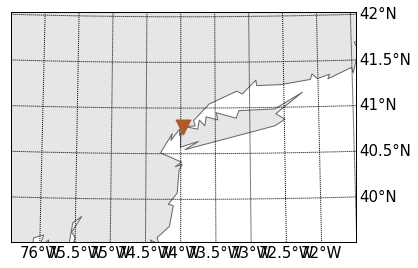

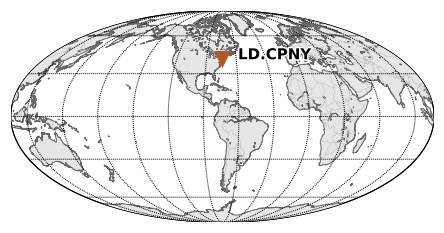

In [24]:
# LOAD STATIONS
t1 = UTCDateTime(tstart)
t2 = UTCDateTime(tend)
inventory = client.get_stations(network=network, station=station, channel=comp, starttime=t1, endtime=t2)
inventory.plot(projection="local",label=False)
fig = inventory.plot(method="basemap", show=True) 

## Download data and do averaging

Loop over windows, download data from IRIS, and calculate RMS ground displacement
$$ RMS = \sqrt{\sum_N\frac{d^2}{N}} $$

In [25]:
winlen_s = winlen_hr*60*60
starttime = (UTCDateTime(tstart)+winlen_s/2).datetime
endtime = (UTCDateTime(tend)-winlen_s/2).datetime
t_cent = pd.date_range(start=starttime, end=endtime, periods=round((endtime-starttime).total_seconds()/winlen_s)+1,tz='UTC')
disp_avg = np.zeros(t_cent.shape)

# Loop through time segements and find average amplitude of filtered envelope
for iday, t in enumerate(t_cent): 
    try:
        # Download data from IRIS
        st = client.get_waveforms(network=network, station=station, location="*", channel=comp, starttime=UTCDateTime(t)-winlen_s/2, endtime=UTCDateTime(t)+winlen_s/2, attach_response=True)
        sr = st[0].stats.sampling_rate
        # Remove instrument response
        st.remove_response(output="DISP", zero_mean=True, taper=True, taper_fraction=0.05, pre_filt=[0.001, 0.005, sr/3, sr/2], water_level=60)
        st.detrend(type='demean')
        st.detrend(type='linear')
        st.taper(type="cosine",max_percentage=0.05)
        # Filter
        st.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
    except:
        print(str(t)+' failed, skip and use previous data segment...')
    
    # Calculate RMS of data segment
    disp_avg[iday] = np.sqrt(np.mean(st[0].data**2))
    print(t)


/Users/russell/anaconda/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


2020-02-09 00:30:00+00:00


/Users/russell/anaconda/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


2020-02-09 01:30:00+00:00
2020-02-09 02:30:00+00:00
2020-02-09 03:30:00+00:00
2020-02-09 04:30:00+00:00
2020-02-09 05:30:00+00:00
2020-02-09 06:30:00+00:00
2020-02-09 07:30:00+00:00
2020-02-09 08:30:00+00:00
2020-02-09 09:30:00+00:00
2020-02-09 10:30:00+00:00
2020-02-09 11:30:00+00:00
2020-02-09 12:30:00+00:00
2020-02-09 13:30:00+00:00
2020-02-09 14:30:00+00:00
2020-02-09 15:30:00+00:00
2020-02-09 16:30:00+00:00
2020-02-09 17:30:00+00:00
2020-02-09 18:30:00+00:00
2020-02-09 19:30:00+00:00
2020-02-09 20:30:00+00:00
2020-02-09 21:30:00+00:00
2020-02-09 22:30:00+00:00
2020-02-09 23:30:00+00:00
2020-02-10 00:30:00+00:00
2020-02-10 01:30:00+00:00
2020-02-10 02:30:00+00:00
2020-02-10 03:30:00+00:00
2020-02-10 04:30:00+00:00
2020-02-10 05:30:00+00:00
2020-02-10 06:30:00+00:00
2020-02-10 07:30:00+00:00
2020-02-10 08:30:00+00:00
2020-02-10 09:30:00+00:00
2020-02-10 10:30:00+00:00
2020-02-10 11:30:00+00:00
2020-02-10 12:30:00+00:00
2020-02-10 13:30:00+00:00
2020-02-10 14:30:00+00:00
2020-02-10 1

2020-02-22 05:30:00+00:00
2020-02-22 06:30:00+00:00
2020-02-22 07:30:00+00:00
2020-02-22 08:30:00+00:00
2020-02-22 09:30:00+00:00
2020-02-22 10:30:00+00:00
2020-02-22 11:30:00+00:00
2020-02-22 12:30:00+00:00
2020-02-22 13:30:00+00:00
2020-02-22 14:30:00+00:00
2020-02-22 15:30:00+00:00
2020-02-22 16:30:00+00:00
2020-02-22 17:30:00+00:00
2020-02-22 18:30:00+00:00
2020-02-22 19:30:00+00:00
2020-02-22 20:30:00+00:00
2020-02-22 21:30:00+00:00
2020-02-22 22:30:00+00:00
2020-02-22 23:30:00+00:00
2020-02-23 00:30:00+00:00
2020-02-23 01:30:00+00:00
2020-02-23 02:30:00+00:00
2020-02-23 03:30:00+00:00
2020-02-23 04:30:00+00:00
2020-02-23 05:30:00+00:00
2020-02-23 06:30:00+00:00
2020-02-23 07:30:00+00:00
2020-02-23 08:30:00+00:00
2020-02-23 09:30:00+00:00
2020-02-23 10:30:00+00:00
2020-02-23 11:30:00+00:00
2020-02-23 12:30:00+00:00
2020-02-23 13:30:00+00:00
2020-02-23 14:30:00+00:00
2020-02-23 15:30:00+00:00
2020-02-23 16:30:00+00:00
2020-02-23 17:30:00+00:00
2020-02-23 18:30:00+00:00
2020-02-23 1

2020-03-05 19:30:00+00:00
2020-03-05 20:30:00+00:00
2020-03-05 21:30:00+00:00
2020-03-05 22:30:00+00:00
2020-03-05 23:30:00+00:00
2020-03-06 00:30:00+00:00
2020-03-06 01:30:00+00:00
2020-03-06 02:30:00+00:00
2020-03-06 03:30:00+00:00
2020-03-06 04:30:00+00:00
2020-03-06 05:30:00+00:00
2020-03-06 06:30:00+00:00
2020-03-06 07:30:00+00:00
2020-03-06 08:30:00+00:00
2020-03-06 09:30:00+00:00
2020-03-06 10:30:00+00:00
2020-03-06 11:30:00+00:00
2020-03-06 12:30:00+00:00
2020-03-06 13:30:00+00:00
2020-03-06 14:30:00+00:00
2020-03-06 15:30:00+00:00
2020-03-06 16:30:00+00:00
2020-03-06 17:30:00+00:00
2020-03-06 18:30:00+00:00
2020-03-06 19:30:00+00:00
2020-03-06 20:30:00+00:00
2020-03-06 21:30:00+00:00
2020-03-06 22:30:00+00:00
2020-03-06 23:30:00+00:00
2020-03-07 00:30:00+00:00
2020-03-07 01:30:00+00:00
2020-03-07 02:30:00+00:00
2020-03-07 03:30:00+00:00
2020-03-07 04:30:00+00:00
2020-03-07 05:30:00+00:00
2020-03-07 06:30:00+00:00
2020-03-07 07:30:00+00:00
2020-03-07 08:30:00+00:00
2020-03-07 0

2020-03-18 23:30:00+00:00
2020-03-19 00:30:00+00:00
2020-03-19 01:30:00+00:00
2020-03-19 02:30:00+00:00
2020-03-19 03:30:00+00:00
2020-03-19 04:30:00+00:00
2020-03-19 05:30:00+00:00
2020-03-19 06:30:00+00:00
2020-03-19 07:30:00+00:00
2020-03-19 08:30:00+00:00
2020-03-19 09:30:00+00:00
2020-03-19 10:30:00+00:00
2020-03-19 11:30:00+00:00
2020-03-19 12:30:00+00:00
2020-03-19 13:30:00+00:00
2020-03-19 14:30:00+00:00
2020-03-19 15:30:00+00:00
2020-03-19 16:30:00+00:00
2020-03-19 17:30:00+00:00
2020-03-19 18:30:00+00:00
2020-03-19 19:30:00+00:00
2020-03-19 20:30:00+00:00
2020-03-19 21:30:00+00:00
2020-03-19 22:30:00+00:00
2020-03-19 23:30:00+00:00
2020-03-20 00:30:00+00:00
2020-03-20 01:30:00+00:00
2020-03-20 02:30:00+00:00
2020-03-20 03:30:00+00:00
2020-03-20 04:30:00+00:00
2020-03-20 05:30:00+00:00
2020-03-20 06:30:00+00:00
2020-03-20 07:30:00+00:00
2020-03-20 08:30:00+00:00
2020-03-20 09:30:00+00:00
2020-03-20 10:30:00+00:00
2020-03-20 11:30:00+00:00
2020-03-20 12:30:00+00:00
2020-03-20 1

2020-04-01 03:30:00+00:00
2020-04-01 04:30:00+00:00
2020-04-01 05:30:00+00:00
2020-04-01 06:30:00+00:00
2020-04-01 07:30:00+00:00
2020-04-01 08:30:00+00:00
2020-04-01 09:30:00+00:00
2020-04-01 10:30:00+00:00
2020-04-01 11:30:00+00:00
2020-04-01 12:30:00+00:00
2020-04-01 13:30:00+00:00
2020-04-01 14:30:00+00:00
2020-04-01 15:30:00+00:00
2020-04-01 16:30:00+00:00
2020-04-01 17:30:00+00:00
2020-04-01 18:30:00+00:00
2020-04-01 19:30:00+00:00
2020-04-01 20:30:00+00:00
2020-04-01 21:30:00+00:00
2020-04-01 22:30:00+00:00
2020-04-01 23:30:00+00:00
2020-04-02 00:30:00+00:00
2020-04-02 01:30:00+00:00
2020-04-02 02:30:00+00:00
2020-04-02 03:30:00+00:00
2020-04-02 04:30:00+00:00
2020-04-02 05:30:00+00:00
2020-04-02 06:30:00+00:00
2020-04-02 07:30:00+00:00
2020-04-02 08:30:00+00:00
2020-04-02 09:30:00+00:00
2020-04-02 10:30:00+00:00
2020-04-02 11:30:00+00:00
2020-04-02 12:30:00+00:00
2020-04-02 13:30:00+00:00
2020-04-02 14:30:00+00:00
2020-04-02 15:30:00+00:00
2020-04-02 16:30:00+00:00
2020-04-02 1

2020-04-14 07:30:00+00:00
2020-04-14 08:30:00+00:00
2020-04-14 09:30:00+00:00
2020-04-14 10:30:00+00:00
2020-04-14 11:30:00+00:00
2020-04-14 12:30:00+00:00
2020-04-14 13:30:00+00:00
2020-04-14 14:30:00+00:00
2020-04-14 15:30:00+00:00
2020-04-14 16:30:00+00:00
2020-04-14 17:30:00+00:00
2020-04-14 18:30:00+00:00
2020-04-14 19:30:00+00:00
2020-04-14 20:30:00+00:00
2020-04-14 21:30:00+00:00
2020-04-14 22:30:00+00:00
2020-04-14 23:30:00+00:00
2020-04-15 00:30:00+00:00
2020-04-15 01:30:00+00:00
2020-04-15 02:30:00+00:00
2020-04-15 03:30:00+00:00
2020-04-15 04:30:00+00:00
2020-04-15 05:30:00+00:00
2020-04-15 06:30:00+00:00
2020-04-15 07:30:00+00:00
2020-04-15 08:30:00+00:00
2020-04-15 09:30:00+00:00
2020-04-15 10:30:00+00:00
2020-04-15 11:30:00+00:00
2020-04-15 12:30:00+00:00
2020-04-15 13:30:00+00:00
2020-04-15 14:30:00+00:00
2020-04-15 15:30:00+00:00
2020-04-15 16:30:00+00:00
2020-04-15 17:30:00+00:00
2020-04-15 18:30:00+00:00
2020-04-15 19:30:00+00:00
2020-04-15 20:30:00+00:00
2020-04-15 2

2020-04-27 08:30:00+00:00
2020-04-27 09:30:00+00:00
2020-04-27 10:30:00+00:00
2020-04-27 11:30:00+00:00
2020-04-27 12:30:00+00:00
2020-04-27 13:30:00+00:00
2020-04-27 14:30:00+00:00
2020-04-27 15:30:00+00:00
2020-04-27 16:30:00+00:00
2020-04-27 17:30:00+00:00
2020-04-27 18:30:00+00:00
2020-04-27 19:30:00+00:00
2020-04-27 20:30:00+00:00
2020-04-27 21:30:00+00:00
2020-04-27 22:30:00+00:00
2020-04-27 23:30:00+00:00
2020-04-28 00:30:00+00:00
2020-04-28 01:30:00+00:00
2020-04-28 02:30:00+00:00
2020-04-28 03:30:00+00:00
2020-04-28 04:30:00+00:00
2020-04-28 05:30:00+00:00
2020-04-28 06:30:00+00:00
2020-04-28 07:30:00+00:00
2020-04-28 08:30:00+00:00
2020-04-28 09:30:00+00:00
2020-04-28 10:30:00+00:00
2020-04-28 11:30:00+00:00
2020-04-28 12:30:00+00:00
2020-04-28 13:30:00+00:00
2020-04-28 14:30:00+00:00
2020-04-28 15:30:00+00:00
2020-04-28 16:30:00+00:00
2020-04-28 17:30:00+00:00
2020-04-28 18:30:00+00:00
2020-04-28 19:30:00+00:00
2020-04-28 20:30:00+00:00
2020-04-28 21:30:00+00:00
2020-04-28 2

2020-05-10 12:30:00+00:00
2020-05-10 13:30:00+00:00
2020-05-10 14:30:00+00:00
2020-05-10 15:30:00+00:00
2020-05-10 16:30:00+00:00
2020-05-10 17:30:00+00:00
2020-05-10 18:30:00+00:00
2020-05-10 19:30:00+00:00
2020-05-10 20:30:00+00:00
2020-05-10 21:30:00+00:00
2020-05-10 22:30:00+00:00
2020-05-10 23:30:00+00:00
2020-05-11 00:30:00+00:00
2020-05-11 01:30:00+00:00
2020-05-11 02:30:00+00:00
2020-05-11 03:30:00+00:00
2020-05-11 04:30:00+00:00
2020-05-11 05:30:00+00:00
2020-05-11 06:30:00+00:00
2020-05-11 07:30:00+00:00
2020-05-11 08:30:00+00:00
2020-05-11 09:30:00+00:00
2020-05-11 10:30:00+00:00
2020-05-11 11:30:00+00:00
2020-05-11 12:30:00+00:00
2020-05-11 13:30:00+00:00
2020-05-11 14:30:00+00:00
2020-05-11 15:30:00+00:00
2020-05-11 16:30:00+00:00
2020-05-11 17:30:00+00:00
2020-05-11 18:30:00+00:00
2020-05-11 19:30:00+00:00
2020-05-11 20:30:00+00:00
2020-05-11 21:30:00+00:00
2020-05-11 22:30:00+00:00
2020-05-11 23:30:00+00:00
2020-05-12 00:30:00+00:00
2020-05-12 01:30:00+00:00
2020-05-12 0

# Build Dataframe and calculate 24 hour moving average

In [ ]:

df = pd.DataFrame({'t_cent': t_cent,
                   'disp_avg': disp_avg})

# Calculate daily averages using boxcar window
dt_hr = (df.t_cent[1]-df.t_cent[0]).seconds/60/60  # Hours between samples
df['daily_average'] = df.disp_avg.rolling(int(24/dt_hr),win_type='boxcar').mean()

In [26]:
# Save File
filename = 'Data/'+network+'.'+station+'.'+str(t1)[0:10]+'.'+str(t2)[0:10]+'.'+str(fmin)+'_'+str(fmax)+'Hz'+'.'+comp+'.csv'
df.to_csv(filename,index=False)

## Plot

NameError: name 'mdates' is not defined

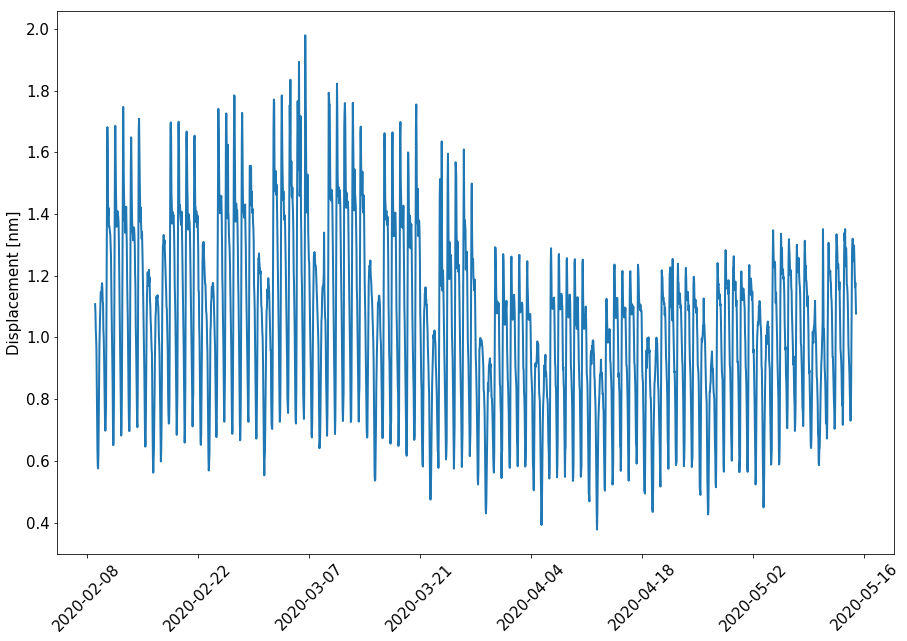

In [27]:
# Plot daily noise
fig = plt.figure(figsize=(15,10))
plt.plot(df.t_cent,df.disp_avg*1e9,'-',linewidth=2)
plt.ylabel('Displacement [nm]')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
